In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
#import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import warnings

## 1) Option Pricing with Heston model
Semi-Analytic Solution

In [2]:
#Heston Model's Characteristic Function
def Heston_CF(u, S0, T, r, kappa, nu0, theta, xi, rho):
    alpha = - u**2 / 2 - 1j * u / 2
    beta = kappa - rho * xi * 1j * u
    gamma = xi**2 / 2
    h = np.sqrt(beta**2 - 4 * alpha * gamma)
    rm = (beta - h) / xi**2
    rp = (beta + h) / xi**2
    g = rm / rp
    C = kappa * (rm * T - 2 / xi**2 * np.log((1 - g * np.exp(-h * T)) / (1 - g)))
    D = rm * (1 - np.exp(-h * T)) / (1 - g * np.exp(-h * T))
    cf = np.exp(C * theta + D * nu0 + 1j * u * np.log(S0 * np.exp(r * T)))
    return cf

#Heston Call Price with midpoint rule
def Heston_price(S0, K, T, r, kappa, nu0, theta, xi, rho):
    params = (S0, T, r, kappa, nu0, theta, xi, rho)
    P1 = 0.5
    P2 = 0.5
    umax = 50
    n = 100
    #remark: we may need to increase umax and n if numerical issues,
    #particularly when options are deep OTM
    du = umax / n
    u = du / 2
    for i in range(n):
        temp1 = np.exp(-1j * u * np.log(K)) * Heston_CF(u - 1j, *params) / (1j * u * Heston_CF(-1j, *params))
        temp2 = np.exp(-1j * u * np.log(K)) * Heston_CF(u, *params) / (1j * u)
        P1 = P1 + 1 / np.pi * temp1 * du
        P2 = P2 + 1 / np.pi * temp2 * du
        u = u + du
    price = np.real(S0 * P1 - K * np.exp(-r * T) * P2)
    return price

In [3]:
# MC Simulation
#simulation asset prices
def simulate_stock_price(S0, T, r, kappa, nu0, theta, xi, rho, N, nstep):
    # Generate random samples for the underlying asset's returns
    np.random.seed()
    dW1 = np.random.normal(size=(N, nstep))
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(size=(N, nstep))
    dt = T / nstep
    # Calculate the asset's returns and volatility at each time step
    S = np.empty((N, nstep))
    v = np.empty((N, nstep))
    S[:, 0] = S0
    v[:, 0] = nu0
    for t in range(1, nstep):
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1] * dt) * dW1[:, t])
        v[:, t] = v[:, t-1] + kappa * (theta - v[:, t-1]) * dt + xi * np.sqrt(v[:, t-1] * dt) * dW2[:, t]
        v[:, t] = [max(0,v[i,t]) for i in range(N)] #to avoid negative variance
    return S
#Pricing vanilla call option by Monte­Carlo Simulations under Heston Model
def Heston_price_MC(S0, K, T, r, kappa, nu0, theta, xi, rho, N, nstep):
    S = simulate_stock_price(S0, T, r, kappa, nu0, theta, xi, rho, N, nstep)
    price = 0
    for i in range(N):
        price = price + 1 / N * max(0, S[i,nstep-1] - K) #average final payoff
    price = price * np.exp(-r * T)
    return price

In [4]:
# Test
S0 = 100 # Initial stock price
K = 120 # strike price
T = 0.5 #time to maturity
r = 0.05 # Risk­free rate
q = 0 # dividend yield
kappa = 0.8 # Mean­reversion speed
nu0 = 0.3**2 # initial variance
theta = 0.3**2 # Long­term variance
xi = 0.5 # Volatility of volatility
rho = -0.8 # Correlation between asset returns and variance

N = 100000
nstep= 100

priceHeston = Heston_price(S0, K, T, r, kappa, nu0, theta, xi, rho)
print("Call Option Price Heston Model (Semi-Analytic Solution):", \
    np.round(priceHeston,3))
priceHestonMC = Heston_price_MC(S0, K, T, r, kappa, nu0, theta, xi, rho, N, nstep)
print("Call Option Price Heston Model (Monte-Carlo Simulations):", \
    np.round(priceHestonMC,3))

Call Option Price Heston Model (Semi-Analytic Solution): 1.552


Call Option Price Heston Model (Monte-Carlo Simulations): 1.543


## 2) PDF recovery from Characteristic function
{cite:p}`GRZ` - https://github.com/LechGrzelak/Computational‑Finance‑Course/blob/main/Lecture%2008‑%20Fourier%20Transformation%20for%20Option%20Pricing/Materials/DensityRecoveryFFT.py

In [5]:
#phi: characteristic function, x: domain for density
def DensityFFT(phi, x, n = 2**10):
    # grid for x
    x_max = np.max(x)+1
    x_min = np.min(x)-1
    dx = (x_max - x_min) / n
    xi = x_min + np.linspace(0,n-1,n) * dx
    #grid for w
    dw = 2 * np.pi / (n * dx)
    w_min = 0
    w_max = + n * dw
    w = w_min + np.linspace(0,n-1,n) * dw
    func = np.exp(-1j * x_min * w) * phi(w)
    # Compute boundaries of the trapezoidal integration rule
    b1 = np.exp(-1j * xi * w[0]) * phi(w[0])
    b2 = np.exp(-1j * xi * w[-1]) * phi(w[-1])
    b = 0.5 * (b1 + b2)
    f_xi = dw / np.pi * np.real(np.fft.fft(func) - b)
    density = interp1d(xi, f_xi, kind='linear')(x)
    return density

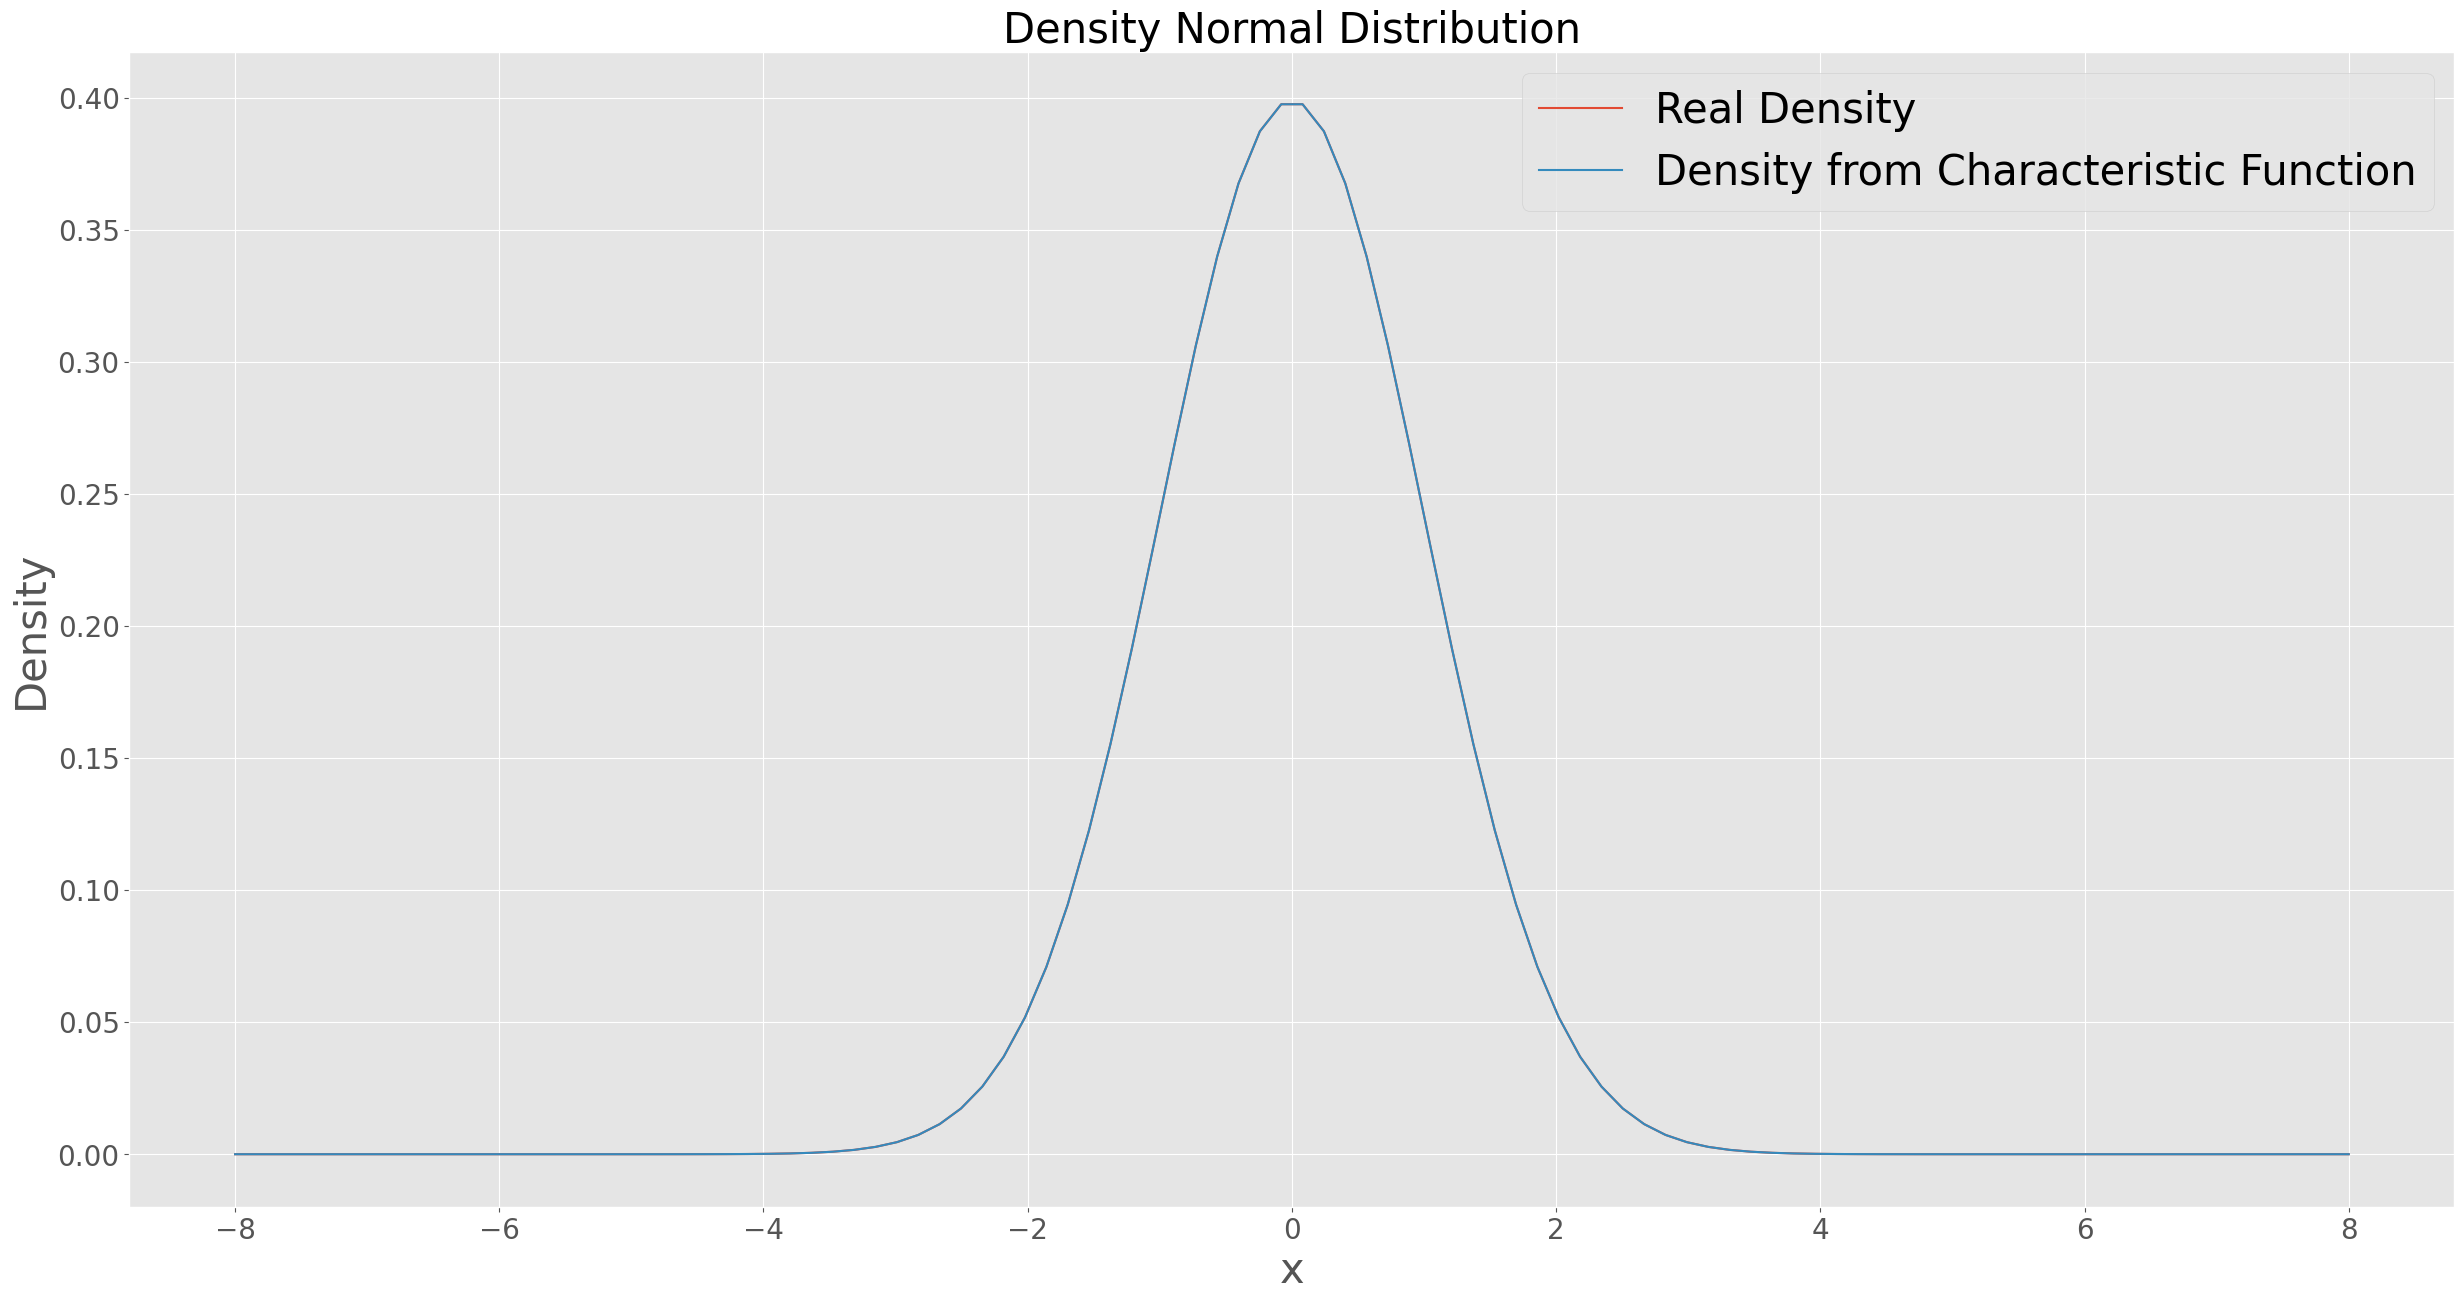

In [6]:
# Normal distribution
#Characteristic function for the normal distribution
def NormalCF(u, mu, sigma):
    return np.exp(1j * mu * u - 0.5 * sigma**2.0 * u**2.0)

#Parameters
mu = 0.0
sigma = 1.0
#Domain for density
x = np.linspace(-8.0,8.0,100)
#Exact density
DensityNormal = norm.pdf(x,mu,sigma)
#Density from characteristic function with FFT
DensityNormal_CF = DensityFFT(lambda u : NormalCF(u, mu, sigma), x, 2**10)
#Chart
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.plot(x, DensityNormal, label="Real Density")
axs.plot(x, DensityNormal_CF, label="Density from Characteristic Function")
axs.set_title('Density Normal Distribution', fontsize = 30,)
axs.set_xlabel('x', fontsize = 30)
axs.set_ylabel('Density', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
axs.legend(fontsize=30)
plt.show()

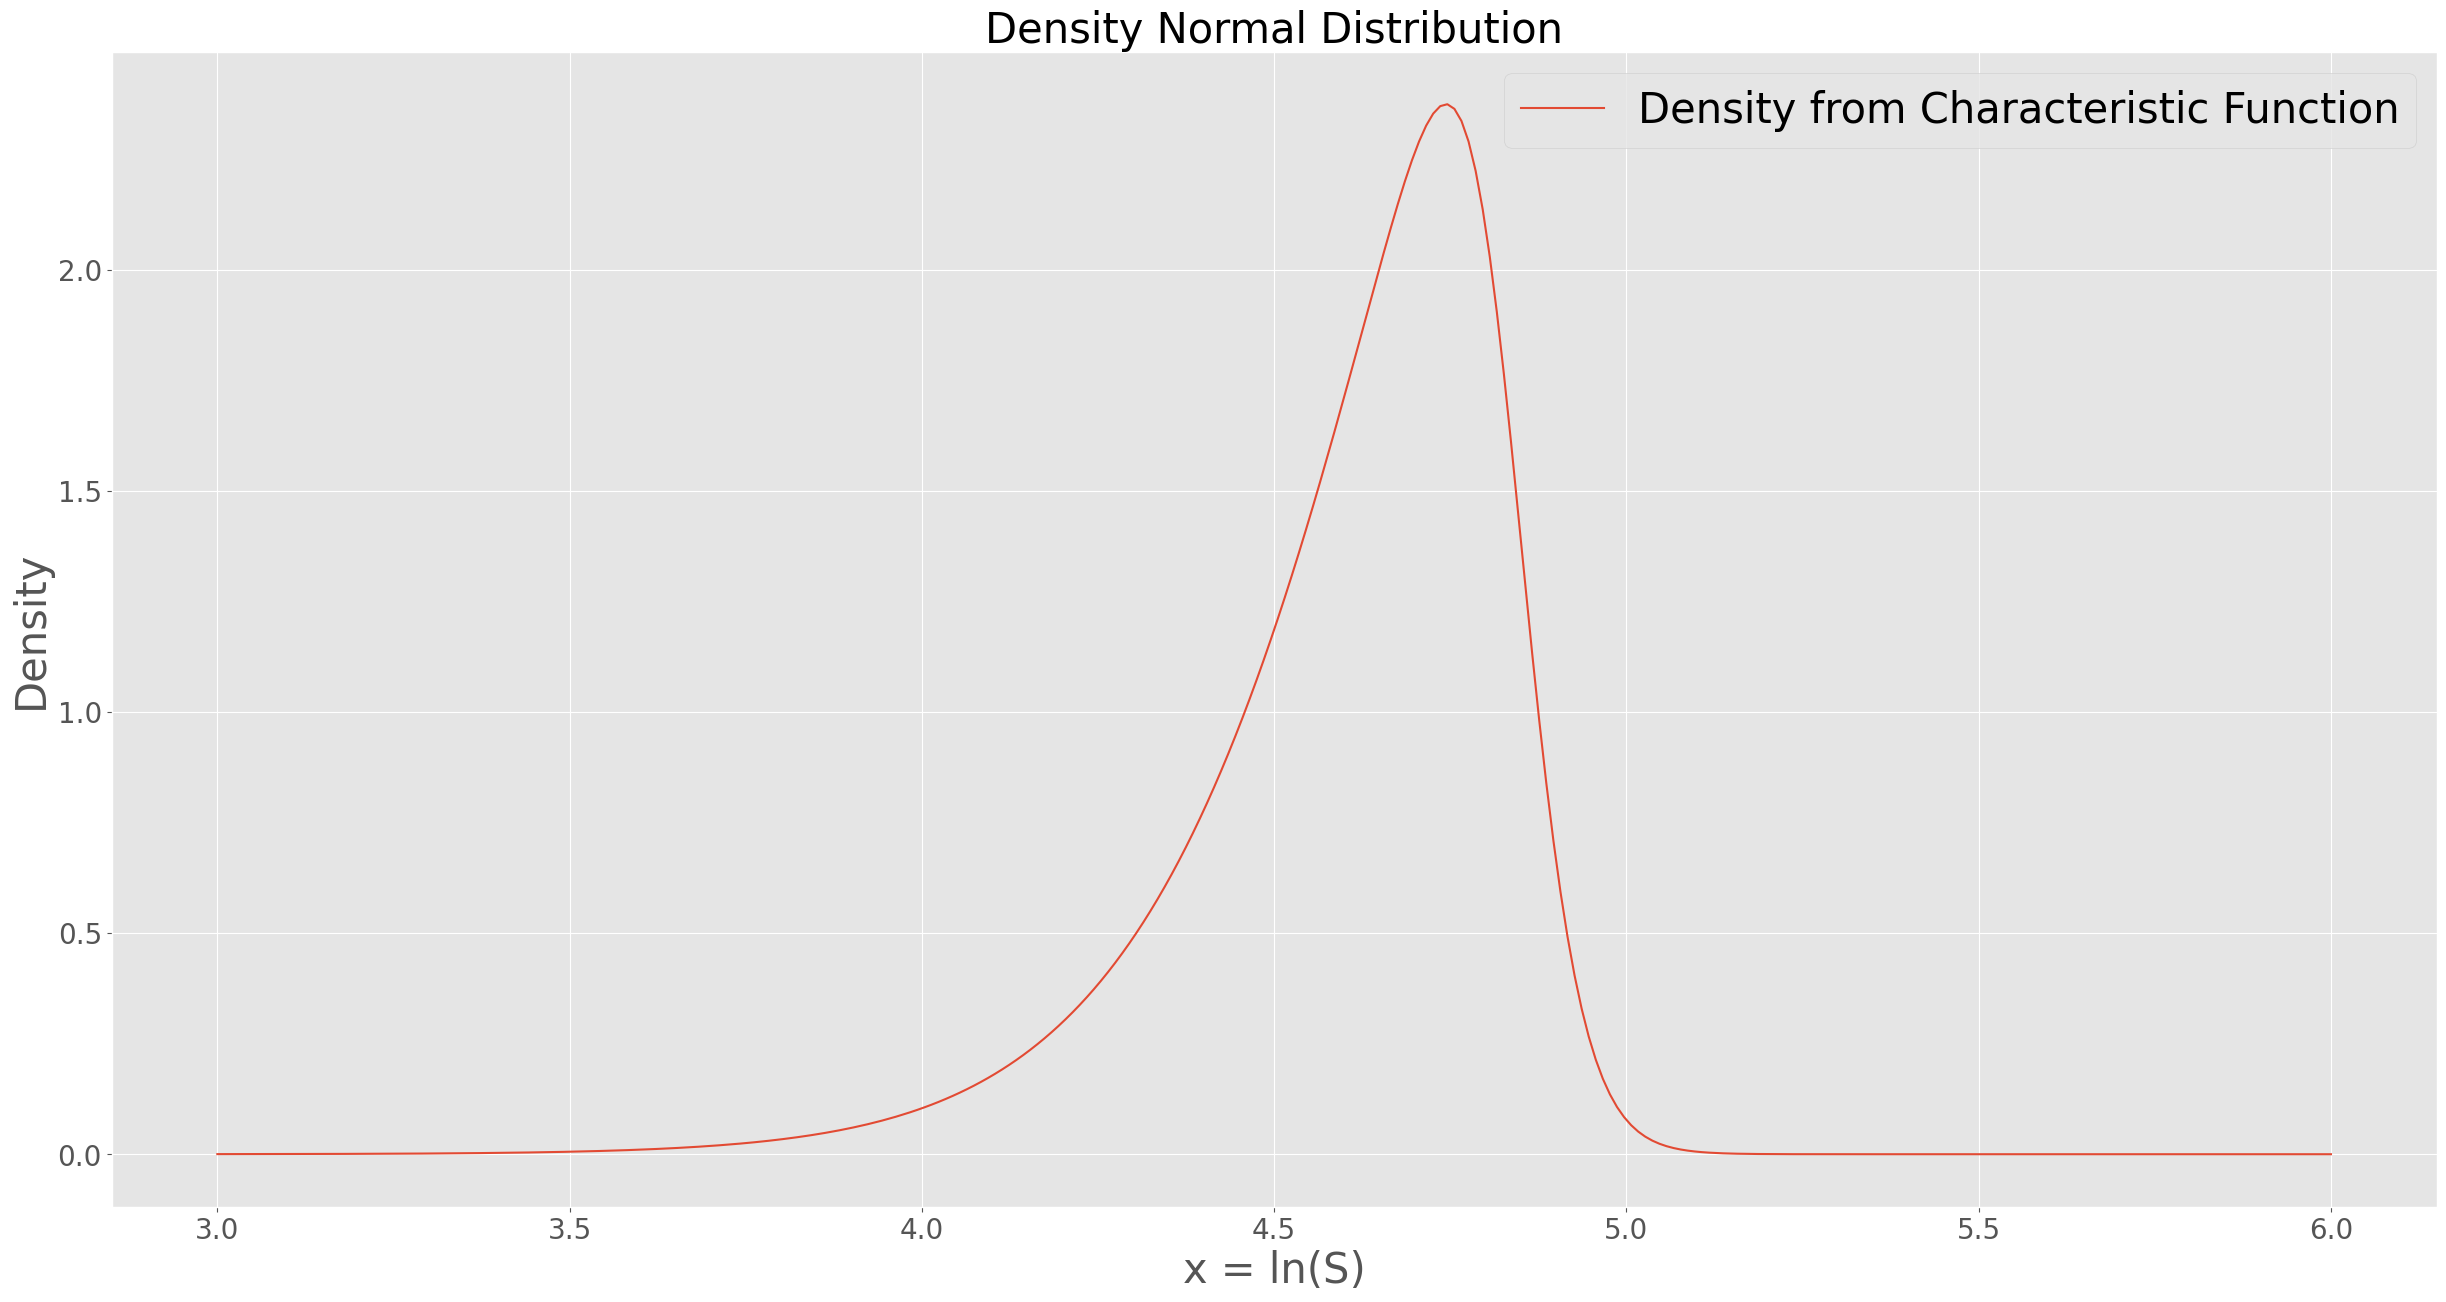

In [7]:
# Heston Distribution
#Parameters
S0 = 100 # Initial stock price
K = 120 # strike price
T = 0.5 #time to maturity
r = 0.05 # Risk­free rate
q = 0 # dividend yield
kappa = 0.8 # Mean­reversion speed
nu0 = 0.3**2 # initial variance
theta = 0.3**2 # Long­term variance
xi = .5 # Volatility of volatility
rho = -0.8 # Correlation between asset returns and variance
#Domain for density
x = np.linspace(3, 6, 300)
#Density from characteristic function with FFT
cf = lambda u : Heston_CF(u, S0, T, r, kappa, nu0, theta, xi, rho)
DensityHeston_CF = DensityFFT(cf, x, 2**10)
#Chart
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.plot(x, DensityHeston_CF, label="Density from Characteristic Function")
axs.set_title('Density Normal Distribution', fontsize = 30,)
axs.set_xlabel('x = ln(S)', fontsize = 30)
axs.set_ylabel('Density', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
axs.legend(fontsize=30)
plt.show()

#### Call Option Price by Numerical Integration 
Becase we have recovered the density of the Heston model for a given set of params, we can evaluate the integral numerically.

In [8]:
#pricing exotic payoff by numerical integration
def PricePayoffDensityHeston(Payoff, r, T):
    x = np.linspace(3, 6, 500)
    dx = x[1] - x[0]
    DensityHeston_CF = DensityFFT(cf, x, 2**10)
    price = 0
    sum_density = 0
    for i in range(len(x)):
        price = price + Payoff(x[i]) * DensityHeston_CF[i]
        sum_density = sum_density + DensityHeston_CF[i] # to have sum density = 1
    price = price * np.exp(-r * T) / sum_density
    return price
def CallPayoff_logprice(x, K):
    return max(0, np.exp(x) - K)

payoff = lambda x: CallPayoff_logprice(x, K)
CallPrice_HestonDensity = PricePayoffDensityHeston(payoff,r, T)
print("Call Option Price Heston Model with density:", \
np.round(CallPrice_HestonDensity,3))
callprice_Heston = Heston_price(S0, K, T, r, kappa, nu0, theta, xi, rho)
print("Call Option Price Heston Model (Semi-Analytic Solution):", \
np.round(callprice_Heston,3))

Call Option Price Heston Model with density: 1.553
Call Option Price Heston Model (Semi-Analytic Solution): 1.552


## 3) Calibration to Market Prices

In [9]:
def CallPrice(S, sigma, K, T, r):
    d1 = (np.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5)
    d2 = d1 - sigma * T**0.5
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    DF = np.exp(-r * T)
    price=S * n1 - K * DF * n2
    return price
def PutPrice(S, sigma, K, T, r):
    d1 = (np.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5)
    d2 = d1 - sigma * T**0.5
    n1 = norm.cdf(-d1)
    n2 = norm.cdf(-d2)
    DF = np.exp(-r * T)
    price= K * DF * n2 - S * n1
    return price

#### Calculate Implied Volatility with Newton-Raphson Method

In [10]:
def InflexionPoint(S, K, T, r):
    m = S / (K * np.exp(-r * T))
    return np.sqrt(2 * np.abs(np.log(m)) / T)
    
def vega(S, sigma, K, T, r):
    d1 = (np.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5)
    vega = S * T**0.5 * norm.pdf(d1)
    return vega

def ImpliedVol(C, S, K, r, T,tol, option_type):
    x0 = InflexionPoint(S, K, T, r)
    if (option_type=="put"): p = PutPrice(S, x0, K, T, r)
    if (option_type=="call"): p = CallPrice(S, x0, K, T, r)
    v = vega(S, x0, K, T, r)
    while (abs((p - C) / v) > tol):
        x0 = x0 - (p - C) / v
        if (option_type=="put"): p = PutPrice(S, x0, K, T, r)
        if (option_type=="call"): p = CallPrice(S, x0, K, T, r)
        v = vega(S, x0, K, T, r)
    return x0

Market Prices

In [11]:
r = 0.05
S0 = 100
IV = [0.28, 0.26, 0.245, 0.24, 0.242, 0.27, 0.26, 0.25, 0.245, 0.242, 0.265, 0.263, 0.26, 0.258, 0.257]
K = [95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105]
T = [0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
Price = [CallPrice(S0, IV[i], K[i], T[i], r) for i in range(len(T))]

MSE

In [12]:
#MSE between call prices
#params = [kappa, nu0, theta, xi, rho]
def MSE_Price(params):
    MSE_Price = 0
    for i in range(len(T)):
        MSE_Price = MSE_Price + (Heston_price(S0, K[i], T[i], r, *params) - Price[i])**2
    return MSE_Price / len(T)

#MSE between implied volatilities
def MSE_IV(params):
    MSE_IV = 0
    for i in range(len(T)):
        Price = Heston_price(S0, K[i], T[i], r, *params)
        HestonIV = ImpliedVol(Price, S0, K[i], r, T[i], 10**-8, "call")
        MSE_IV = MSE_IV + (HestonIV- IV[i])**2
    return MSE_IV / len(T)

#Constraints
cons=(
    {'type': 'ineq', 'fun': lambda x: 1.0 - x[4]}, #rho <= 1
    {'type': 'ineq', 'fun': lambda x: x[4] + 1.0}, #rho >= ­1
    {'type': 'ineq', 'fun': lambda x: x[3] - 0.00001}, #xi > 0
    {'type': 'ineq', 'fun': lambda x: x[0] - 0.00001}, #kappa > 0
    {'type': 'ineq', 'fun': lambda x: x[1] - 0.00001}, #nu0 > 0
    {'type': 'ineq', 'fun': lambda x: x[2] - 0.00001}, #theta > 0
    #Feller condition: 2 x kappa x theta ­ xi^2 > 0
    {'type': 'ineq', 'fun': lambda x: 2 * x[0] * x[2] - x[3]**2 - 0.00001}
)

In [13]:
warnings.filterwarnings('ignore')
#params = [kappa, nu0, theta, xi, rho]
params = [2, 0.25**2, 0.25**2, 0.5, -0.8] #initial params
result = minimize(MSE_Price, params, constraints = cons, method = 'SLSQP', tol=1e-6)
print(result)

new_params = result['x']
new_params # [kappa, nu0, theta, xi, rho]

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.00941835689588711
       x: [ 7.105e+00  6.564e-02  7.209e-02  1.012e+00 -6.359e-01]
     nit: 35
     jac: [ 2.080e-04 -3.007e-03  8.210e-03 -3.062e-03 -8.217e-05]
    nfev: 217
    njev: 35


array([ 7.1049145 ,  0.06563898,  0.0720909 ,  1.01212155, -0.63586122])

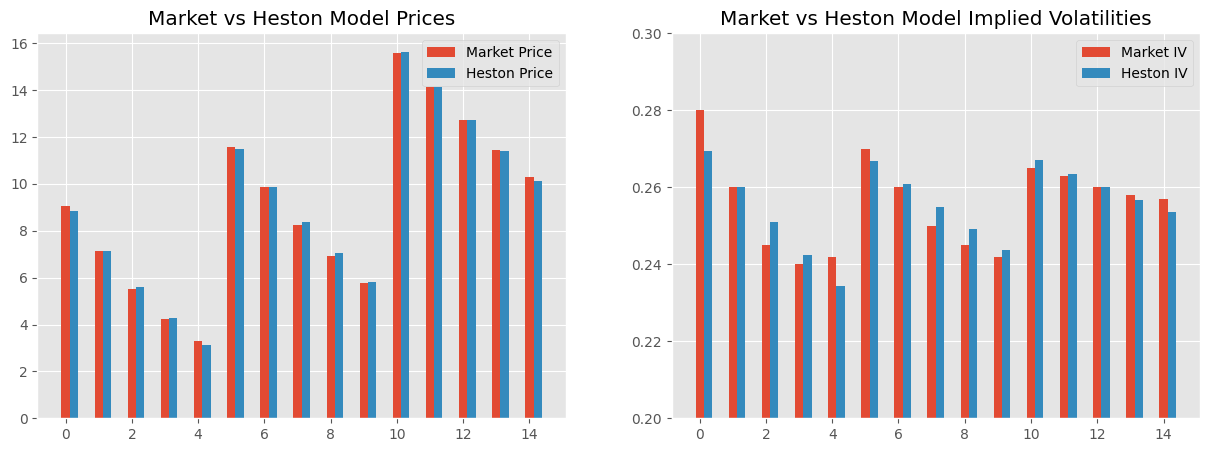

In [14]:
Price_Heston = [Heston_price(S0, K[i], T[i], r, *new_params) for i in range(len(T))]
IV_Heston = [ImpliedVol(Price_Heston[i], S0, K[i], r, T[i], 10**-8, "call") for i in range(len(T))]

fig, axs = plt.subplots(1, 2, figsize=(15,5))
X = np.arange(15)

axs[0].bar(X, Price, width = 0.25)
axs[0].bar(X + 0.25, Price_Heston, width = 0.25)
axs[0].legend(labels=['Market Price', 'Heston Price'])
axs[0].set_title('Market vs Heston Model Prices')

axs[1].bar(X, IV, width = 0.25)
axs[1].bar(X + 0.25, IV_Heston, width = 0.25)
axs[1].legend(labels=['Market IV', 'Heston IV'])
axs[1].set_title('Market vs Heston Model Implied Volatilities')
axs[1].set_ylim([0.2, 0.3])

plt.show()

## 4) Pricing of a Down‑and‑In Put Barrier Option (Path Dependent)

In [15]:
#Down­and­in­call
def CallPriceDownOut(S0, B, K, T, r, N, nstep, kappa, nu0, theta, xi, rho):
    S = simulate_stock_price(S0, T, r, kappa, nu0, theta, xi, rho, N, nstep)
    price = 0
    test = 0
    min_ = S0
    for i in range(N):
        min_ = min(S[i, :])
        if min_ > B: price = price + 1 / N * max(0, S[i,nstep-1] - K)
        price = price * np.exp(-r * T)
    return price

In [16]:
# Parameters
S0 = 100 #Stock Price
B = 95 #Barrier Level
K = 120 #Strike Price
T = 0.5 #Time to maturity
r = 0.05 #Risk­free interest­rate
N = 10000 #Number of simulations
nstep = 100 #Number of time steps
price = CallPriceDownOut(S0, B, K, T, r, N, nstep, *new_params)
print("Price down-and-out call option:", np.round(price,3))

Price down-and-out call option: 0.006


Sensitivity to a decrease of correlation:

The price of the barrier option decreases when the correlation is more negative.

A more negative correlation increases the asymmetry of the return distribution,
with a higher risk of negative returns (negative skewness)
and a higher probability that the barrier will be reached.

In [17]:
#params = [kappa, nu0, theta, xi, rho]
new_params

array([ 7.1049145 ,  0.06563898,  0.0720909 ,  1.01212155, -0.63586122])

In [18]:
new_params1 = [new_params[i] for i in range(len(new_params))]
new_params1[4] = new_params1[4] - 0.1
new_params1

[np.float64(7.104914500140112),
 np.float64(0.06563897794659962),
 np.float64(0.0720908994099902),
 np.float64(1.01212155067738),
 np.float64(-0.7358612222114196)]

In [19]:
price = CallPriceDownOut(S0, B, K, T, r, N, nstep, *new_params1)
print("Price down-and-out call option:", np.round(price,3))

Price down-and-out call option: 0.001


Sensitivity to an increase of the vol of vol
The price of the barrier option decreases as well when we increase the vol of vol parameters.
A higher vol of vol (higher tail risk / volatility smile) increases the probability that the
barrier will be reached.

In [20]:
new_params1 = [new_params[i] for i in range(len(new_params))]
new_params1[3] = new_params1[3] + 1.
new_params1

[np.float64(7.104914500140112),
 np.float64(0.06563897794659962),
 np.float64(0.0720908994099902),
 np.float64(2.0121215506773797),
 np.float64(-0.6358612222114196)]

In [21]:
price = CallPriceDownOut(S0, B, K, T, r, N, nstep, *new_params1)
print("Price down-and-out call option:", np.round(price,3))

Price down-and-out call option: 0.002


## 5) Pricing Exotic EU Payoff (Path Independent)
- We price here an exotic option payoff using the density function estimated
by FFT.

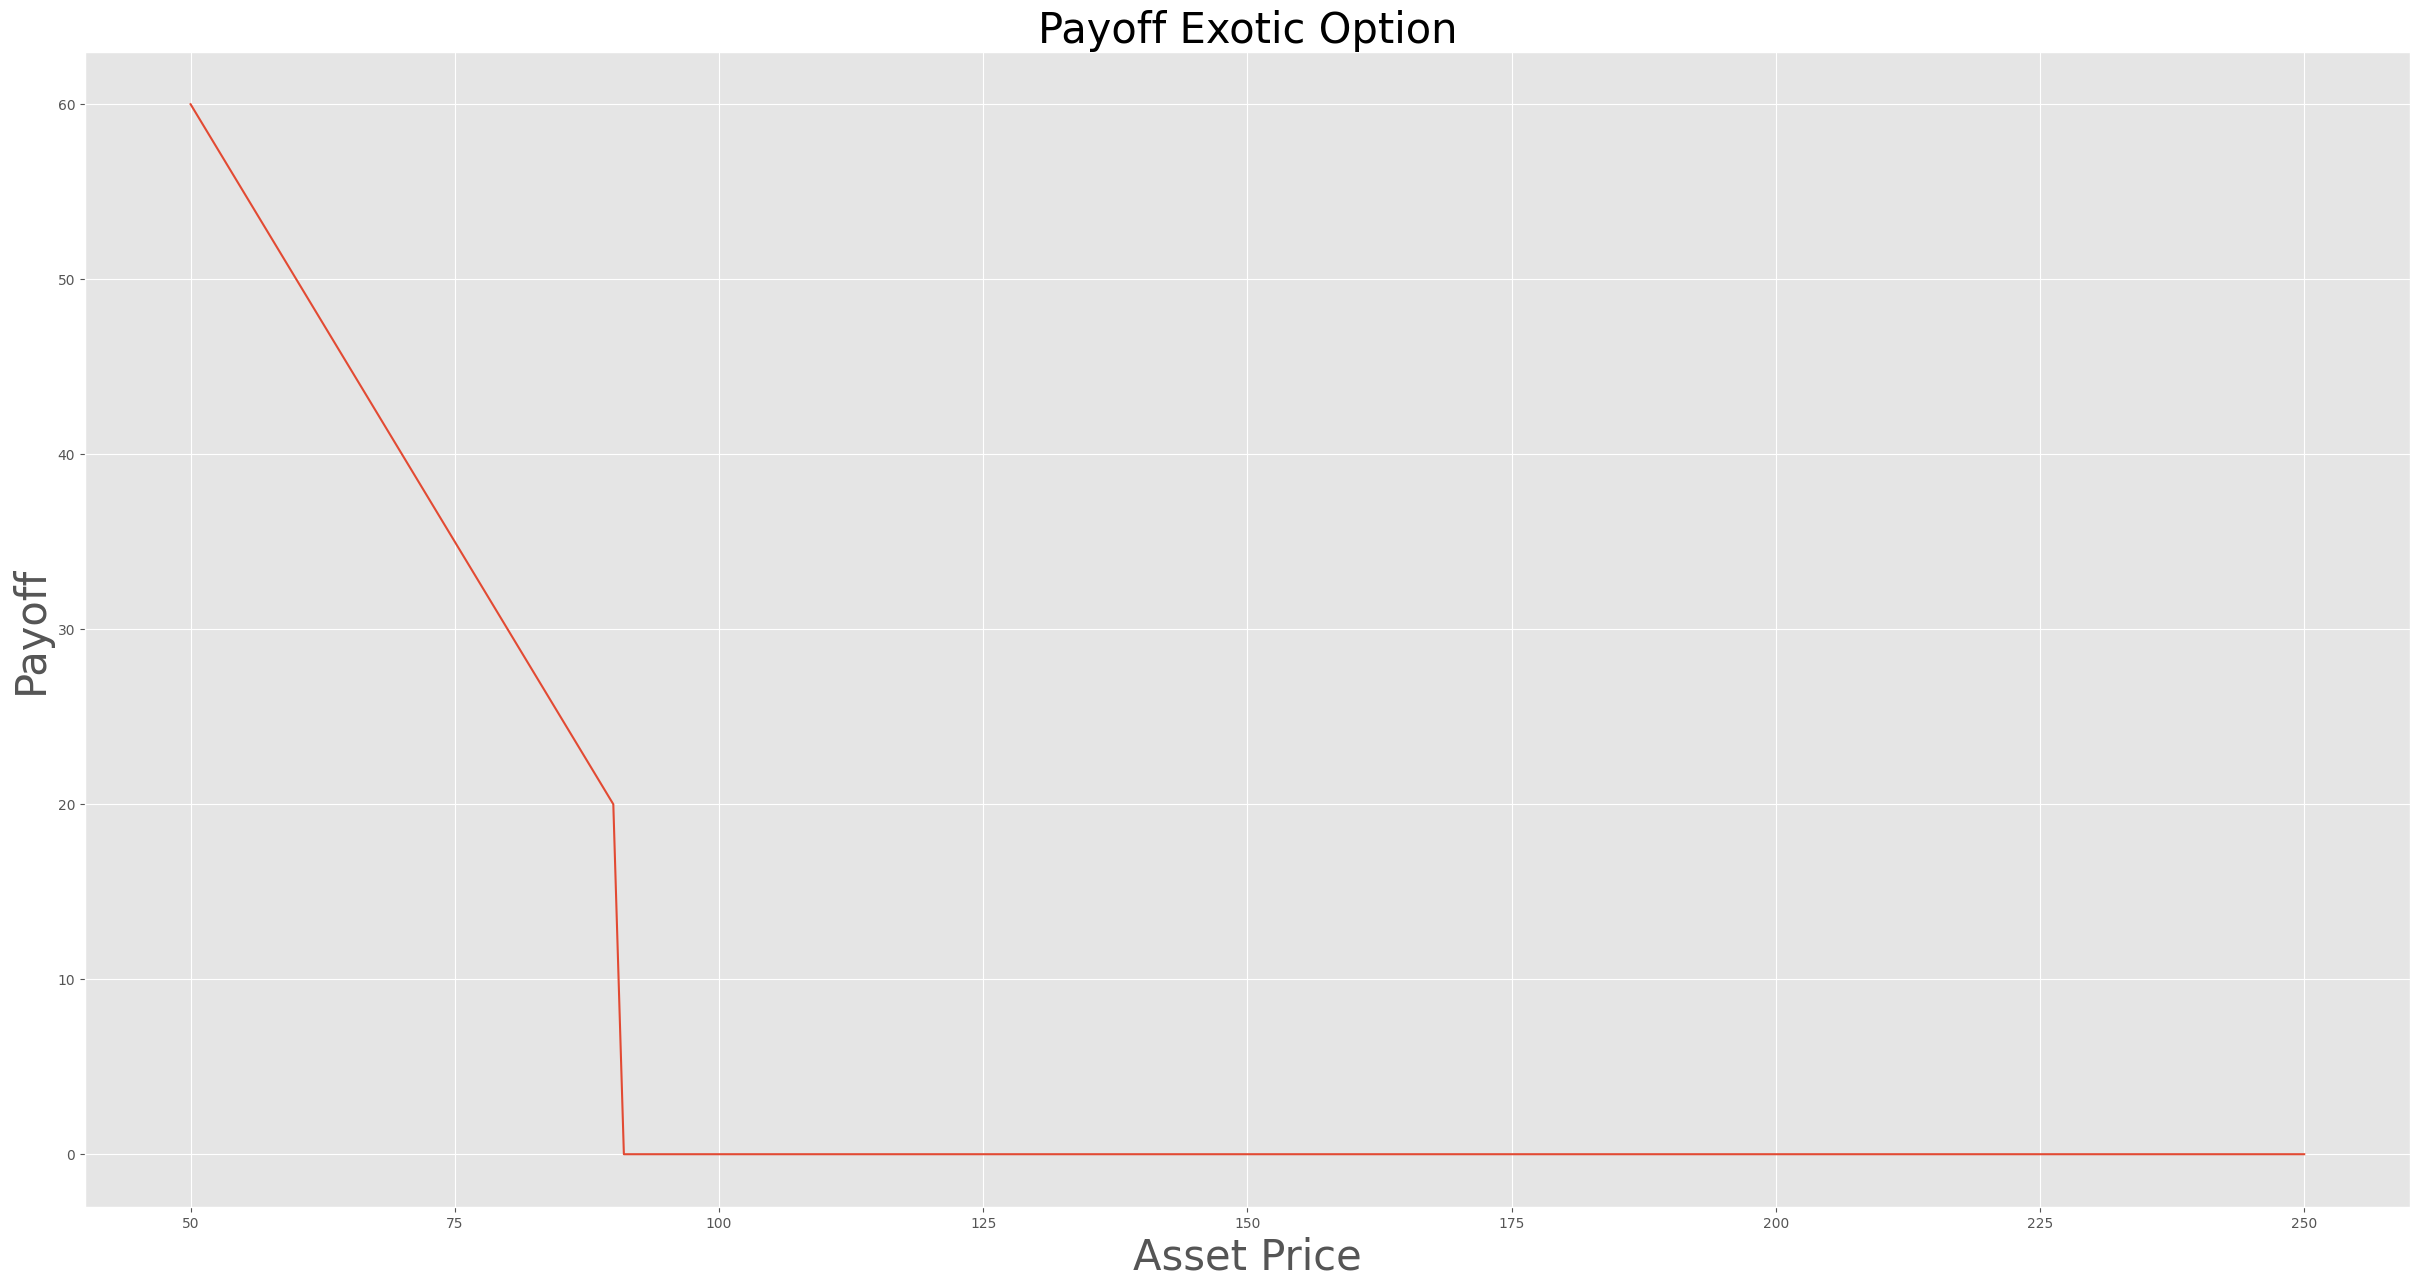

In [22]:
def PayoffExo(x):
    if x <= 90:
        payoff = max(0, 110 - x)
    else:
        payoff = 0
    return payoff

fig, axs = plt.subplots(1,figsize = (30, 15))
x = range(50, 251)
axs.plot(x, [PayoffExo(x_) for x_ in x])
axs.set_xlabel('Asset Price', fontsize = 30)
axs.set_ylabel('Payoff', fontsize = 30)
axs.set_title('Payoff Exotic Option', fontsize = 30)
plt.show()

In [23]:
r = .05 #risk­free interest rate
T = .25 #time to maturity
#Characteristic function
cf = lambda u : Heston_CF(u, S0, T, r, *new_params)
ExoPrice_HestonDensity = PricePayoffDensityHeston(lambda x: PayoffExo(np.exp(x)), r, T)
print("Exotic Option Price Heston Model with density:", \
np.round(ExoPrice_HestonDensity, 3))

Exotic Option Price Heston Model with density: 5.063


Sensitivity to a decrease of correlation

The price of the barrier option decreases when the correlation is more negative.
A more negative correlation increases the asymmetry of the return distribution,
with a higher risk of negative returns (negative sk
ewness)
and a higher probability that the barrier will be reached.

Role of rho (Correlation) in the Heston Model ρ is the correlation between the Brownian motion driving the asset price and the Brownian motion driving its variance.
In the Heston model, 
- a large negative ρ (often observed in equity markets) produces a left-skewed implied volatility curve — higher IV for low strikes (OTM puts) than for high strikes.
- A large positive ρ produces right-skew — higher IV for high strikes.

In [24]:
#params = [kappa, nu0, theta, xi, rho]
new_params

array([ 7.1049145 ,  0.06563898,  0.0720909 ,  1.01212155, -0.63586122])

In [25]:
new_params1 = [new_params[i] for i in range(len(new_params))]
new_params1[4] = new_params1[4] - 0.2
new_params1

[np.float64(7.104914500140112),
 np.float64(0.06563897794659962),
 np.float64(0.0720908994099902),
 np.float64(1.01212155067738),
 np.float64(-0.8358612222114197)]

In [26]:
#Characteristic function
cf = lambda u : Heston_CF(u, S0, T, r,*new_params1)
ExoPrice_HestonDensity = PricePayoffDensityHeston(lambda x: PayoffExo(np.exp(x)), r, T)
print("Exotic Option Price Heston Model with density:", \
np.round(ExoPrice_HestonDensity, 3))

Exotic Option Price Heston Model with density: 5.11


Sensitivity to an increase of vol of vol

In [27]:
new_params1 = [new_params[i] for i in range(len(new_params))]
new_params1[3] = new_params1[3] + .5
new_params1

[np.float64(7.104914500140112),
 np.float64(0.06563897794659962),
 np.float64(0.0720908994099902),
 np.float64(1.51212155067738),
 np.float64(-0.6358612222114196)]

In [28]:
#Characteristic function
cf = lambda u : Heston_CF(u, S0, T, r, *new_params1)
ExoPrice_HestonDensity = PricePayoffDensityHeston(lambda x: PayoffExo(np.exp(x)), r, T)
print("Exotic Option Price Heston Model with density:", \
np.round(ExoPrice_HestonDensity, 3))

Exotic Option Price Heston Model with density: 4.741


A decrease of the correlation parameter has a small impact on the option price while an increase of the vol of vol parameter decreases the price of the exotic option with a higher probability to have a zero payoff at maturity.